In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from utilities.recalibration_conformal import *
from models import seq2point_gaussian
import scipy.stats as st
from mapie.metrics import regression_coverage_score
from sklearn.isotonic import IsotonicRegression
from tueplots import bundles
import time as time
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Function Definitions

In [4]:
def find_coverage_calib(y, y_noisy, sigmas, ci, flag=False):
    alpha = 1 - ci                  # size = len(ci)
    k = st.norm.ppf(1 - alpha / 2)  # size = len(ci)
    q_hats = []
    times = []
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_noisy + k[i] * sigmas
            lower = y_noisy - k[i] * sigmas
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            # tb = time.time()
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                q_hats.append(0)
                continue
            initial_upper = y_noisy + k[i] * sigmas
            initial_lower = y_noisy - k[i] * sigmas
            upper_err = np.array(y).reshape(-1) - \
                np.array(initial_upper).reshape(-1)
            lower_err = np.array(initial_lower).reshape(-1) - \
                np.array(y).reshape(-1)
            E_i = np.max(np.vstack((lower_err, upper_err)), axis=0)
            # E_i = []
            # for j in range(len(y)):
            #     E_i.append(
            #         max(y_noisy[j] - initial_upper[j], initial_lower[j] - y_noisy[j]))

            q_level = np.ceil((len(y)+1)*ci[i])/len(y)
            # print("q_level: ", q_level)
            q_hat = np.quantile(E_i, q_level, method='higher')
            q_hats.append(q_hat)
            upper = initial_upper + q_hat
            lower = initial_lower - q_hat
            # ta = time.time()
            # times.append(ta-tb)
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
            # check if 0 is in ci array and if so, set coverage to 0 at that index

    return coverage, q_hats, times

In [5]:
def find_coverage_train_test(y, y_noisy, sigmas, ci, q_hats, flag=False):
    alpha = 1 - ci                  # size = len(ci)
    k = st.norm.ppf(1 - alpha / 2)  # size = len(ci)
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_noisy + k[i] * sigmas
            lower = y_noisy - k[i] * sigmas
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                continue
            upper = y_noisy + k[i] * sigmas + q_hats[i]
            lower = y_noisy - k[i] * sigmas - q_hats[i]
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
            # check if 0 is in ci array and if so, set coverage to 0 at that index

    return coverage, q_hats

In [6]:
def calib_errors(ci, coverages):
    ece = 0.0
    ace = 0.0
    for i in range(len(ci)):
        ace += abs(ci[i]-coverages[i])
    ece = ace/len(ci)
    return ace, ece

# Model Training

In [7]:
train = {
    1: {
        'start_time': "2011-04-28",
        'end_time': "2011-05-15"
    },
    3: {
        'start_time': "2011-04-19",
        'end_time': "2011-05-22"
    }
}
test = {
    2: {
        'start_time': "2011-04-21",
        'end_time': "2011-05-21"
    }
}
appliances = ["Dish Washer"]

In [8]:
datas = dataset_load(appliances, train, test, 99, split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test, y_test = datas[4], datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [9]:
training_predictions_df = pd.DataFrame()
testing_predictions_df = pd.DataFrame()
calibration_predictions_df = pd.DataFrame()
training_predictions_df["Ground Truth"] = scaler_y.inverse_transform(y_train)[
    :, 0]
calibration_predictions_df['Ground Truth'] = scaler_y.inverse_transform(y_cal)[
    :, 0]
testing_predictions_df["Timestamp"] = x_test_timestamp
testing_predictions_df["Ground Truth"] = y_test

In [10]:
model = seq2point_gaussian.seq2point()

In [11]:
%%capture cap --no-stderr
%%time
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False, batch_size=1024, learning_rate=0.0001, epochs=50)

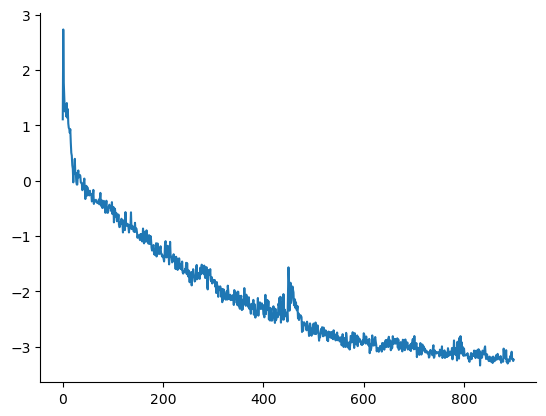

In [12]:
plt.plot(losses)
sns.despine()

In [13]:
mlp_training_time = cap.stdout.split('\n')[1]
mlp_training_time

'Wall time: 11.3 s'

# Before Calibration

##### Results on Calibration Set

In [14]:
%%capture cap
%%time
y_hat = model.apply(params, x_cal, True, rngs={
                    "dropout": jax.random.PRNGKey(0)})

In [15]:
cal_mean = scaler_y.inverse_transform(y_hat[0])
cal_sigma = scaler_y.scale_*y_hat[1]
y_true_cal = scaler_y.inverse_transform(y_cal)

In [16]:
print(f"RMSE : {errors.rmse(y_true_cal, cal_mean):.4f} MAE  : {errors.mae(y_true_cal, cal_mean):.4f} NLL : {errors.NLL(cal_mean,cal_sigma,y_true_cal):.4f}")

RMSE : 77.4821 MAE  : 10.4152 NLL : 1.8992


In [17]:
mlp_calibration_time = cap.stdout.split('\n')[1]
mlp_calibration_time

'Wall time: 1.38 s'

##### Results on Training Set

In [18]:
y_hat_train = model.apply(params, x_train, True, rngs={
    "dropout": jax.random.PRNGKey(0)})

In [19]:
train_mean = scaler_y.inverse_transform(y_hat_train[0])
train_sigma = scaler_y.scale_*y_hat_train[1]
y_train_scaled = scaler_y.inverse_transform(y_train)

In [20]:
print(f"RMSE : {errors.rmse(y_train_scaled, train_mean):.4f} MAE  : {errors.mae(y_train_scaled, train_mean):.4f} NLL : {errors.NLL(train_mean,train_sigma,y_train_scaled):.4f}")

RMSE : 85.2581 MAE  : 12.1228 NLL : 1.9227


##### Results on Test Set

In [21]:
%%capture cap
%%time
y_hat_test = model.apply(params, x_test, True, rngs={
    "dropout": jax.random.PRNGKey(0)})

In [22]:
test_mean = scaler_y.inverse_transform(y_hat_test[0])
test_sigma = scaler_y.scale_*y_hat_test[1]

In [23]:
print(f"RMSE : {errors.rmse(y_test, test_mean):.4f} MAE  : {errors.mae(y_test, test_mean):.4f} NLL : {errors.NLL(test_mean,test_sigma,y_test):.4f}")

RMSE : 92.4599 MAE  : 9.6550 NLL : 1.9476


In [24]:
mlp_testing_time = cap.stdout.split('\n')[1]
mlp_testing_time

'Wall time: 1.5 s'

# After Calibration

### Conformal Prediction

##### Results on Calibration Set

In [38]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_cal, _, _ = find_coverage_calib(
    y_true_cal, cal_mean, cal_sigma, ci)

In [39]:
%%capture cap
%%time
flag = True
final_coverages_cal, q_hats, times = find_coverage_calib(
    y_true_cal, cal_mean, cal_sigma, ci, flag=flag)

In [51]:
ace_init_cal, ece_init_cal = calib_errors(ci, initial_coverages_cal)
ace_fin_cal, ece_fin_cal = calib_errors(ci, final_coverages_cal)

In [52]:
print('Calibration:')
print(f'Initial ace error is {ace_init_cal} and ece error is {ece_init_cal}')
print(f'Final ace error is {ace_fin_cal} and ece error is {ece_fin_cal}')

Calibration:
Initial ace error is 1.961316122673452 and ece error is 0.17830146569758654
Final ace error is 0.002247355878353091 and ece error is 0.000204305079850281


##### Results on Training Set

In [53]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_train, _ = find_coverage_train_test(
    y_train_scaled, train_mean, train_sigma, ci, [])
initial_coverages_train

array([0.        , 0.01498288, 0.05602526, 0.09391053, 0.13415025,
       0.1854666 , 0.25064212, 0.3416096 , 0.6344713 , 0.81892121,
       1.        ])

In [54]:
q_hats

[0,
 0.46642414,
 0.5382784,
 0.54672694,
 0.5007656,
 0.41887116,
 0.3354482,
 0.26688796,
 0.21796545,
 0.12596837,
 0]

In [55]:
flag = True
final_coverages_train, q_hats = find_coverage_train_test(
    y_train_scaled, train_mean, train_sigma, ci, q_hats, flag=flag)
print(final_coverages_train)

[0.         0.09380351 0.19846961 0.29564425 0.39677867 0.49828768
 0.60033178 0.69718534 0.80227953 0.90480524 1.        ]


In [57]:
ace_init_train, ece_init_train = calib_errors(ci, initial_coverages_train)
ace_fin_train, ece_fin_train = calib_errors(ci, final_coverages_train)

In [58]:
print('Train:')
print(
    f'Initial ace error is {ace_init_train} and ece error is {ece_init_train}')
print(f'Final ace error is {ace_fin_train} and ece error is {ece_fin_train}')

Train:
Initial ace error is 1.9698202600702643 and ece error is 0.17907456909729677
Final ace error is 0.0272474974393844 and ece error is 0.002477045221762218


##### Results on Test Set

In [59]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_test, _ = find_coverage_train_test(
    y_test, test_mean, test_sigma, ci, [])
initial_coverages_test

array([0.        , 0.00849515, 0.02101431, 0.04049566, 0.07102708,
       0.12161472, 0.19724067, 0.32211292, 0.55282319, 0.87634134,
       1.        ])

In [60]:
q_hats

[0,
 0.46642414,
 0.5382784,
 0.54672694,
 0.5007656,
 0.41887116,
 0.3354482,
 0.26688796,
 0.21796545,
 0.12596837,
 0]

In [61]:
flag = True
final_coverages_test, q_hats = find_coverage_train_test(
    y_test, test_mean, test_sigma, ci, q_hats, flag=flag)
print(final_coverages_test)

[0.         0.19928461 0.40208226 0.55806082 0.63062084 0.64895248
 0.68037814 0.76328564 0.8881579  0.95995146 1.        ]


In [62]:
ace_init_test, ece_init_test = calib_errors(ci, initial_coverages_test)
ace_fin_test, ece_fin_test = calib_errors(ci, final_coverages_test)

In [63]:
print(f'Initial ace error is {ace_init_test} and ece error is {ece_init_test}')
print(f'Final ace error is {ace_fin_test} and ece error is {ece_fin_test}')

Initial ace error is 2.288834984414279 and ece error is 0.20807590767402537
Final ace error is 1.230774164199829 and ece error is 0.11188856038180264


##### Comparison of Results

In [65]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

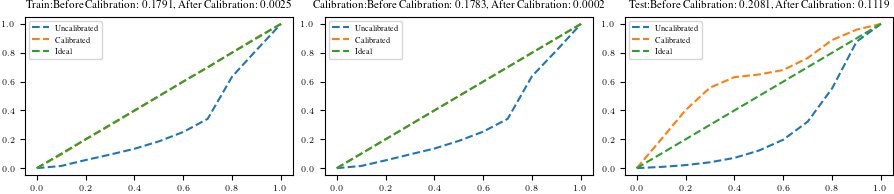

In [66]:
# Train
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (9, 2)})
plt.subplot(1, 3, 1)
plt.plot(ci, initial_coverages_train, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_train, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Train:Before Calibration: {"{:.4f}".format(ece_init_train)}, After Calibration: {"{:.4f}".format(ece_fin_train)}')
plt.legend()

# Calibration
plt.subplot(1, 3, 2)
plt.plot(ci, initial_coverages_cal, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_cal, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Calibration:Before Calibration: {"{:.4f}".format(ece_init_cal)}, After Calibration: {"{:.4f}".format(ece_fin_cal)}')
plt.legend()

# Test
plt.subplot(1, 3, 3)
plt.plot(ci, initial_coverages_test, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_test, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Test:Before Calibration: {"{:.4f}".format(ece_init_test)}, After Calibration: {"{:.4f}".format(ece_fin_test)}')
plt.legend()
# plt.savefig(
#     f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Hetero_Conformal_Conformal.pdf')